In [134]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import json
from matplotlib import pyplot as plt

dataframes = ["TheftEvent.parquet", "VisionEvent.parquet"]
attach_config_vars = ["generation_empty_w"]

folder = Path(".").resolve() / "data" / "experiments"
regex = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_(\d{5})"


def load_experiments_by_name(name) -> dict[str, pd.DataFrame]:

    dfs = {dfname: [] for dfname in dataframes}

    for ent in (folder / name).iterdir():

        if not ent.is_dir():
            continue

        res = re.match(regex, ent.name)
        
        if res is None:
            continue

        dstr, randstr = res.group(1), res.group(2)

        if not (ent / "config.json").is_file():
            continue

        with open(ent / "config.json", "r", encoding="utf-8") as f:
            config = json.load(f)
        
        skip_log = not all([(ent / dfname).is_file() for dfname in dataframes])
    
        if skip_log:
            continue

        for dfname in dataframes:
            df = pd.read_parquet(ent / dfname) 
            df["rand"]= ent.name
            
            for av in attach_config_vars:
                df[av] = config[av]
            
            dfs[dfname].append(df)

        

    
    dfs = {dfname: pd.concat(inners, ignore_index=True) for dfname, inners in dfs.items()}

    return dfs

dfs = load_experiments_by_name("motivation_high_effect")
df = dfs["TheftEvent.parquet"]
vision = dfs["VisionEvent.parquet"]

In [135]:
df

,caught,thief_i,target_i,vision,cos_angle,t,rand,generation_empty_w
0,False,129,111,0.000000,-0.958074,1292,2024-10-02_12-40-56_72762,1.0
1,False,127,8,0.000000,-0.996969,1785,2024-10-02_12-40-56_72762,1.0
2,False,129,111,0.000000,-0.953454,2584,2024-10-02_12-40-56_72762,1.0
3,True,124,104,0.215721,-0.927191,2992,2024-10-02_12-40-56_72762,1.0
4,True,123,106,0.377500,-0.400802,3213,2024-10-02_12-40-56_72762,1.0
...,...,...,...,...,...,...,...,...
88090,True,127,21,0.132500,-0.523180,138669,2024-10-02_12-45-43_69623,50.0
88091,True,122,27,0.000000,0.643971,139060,2024-10-02_12-45-43_69623,50.0
88092,False,121,94,0.198750,-0.110965,139145,2024-10-02_12-45-43_69623,50.0
88093,True,126,38,1.000000,0.319230,139264,2024-10-02_12-45-43_69623,50.0


In [136]:



def custom():
    cubes = []
    empty_w = []

    for rand in vision["rand"].unique():
        df = vision[vision["rand"] == rand]
        var_interest = df["generation_empty_w"]

        if (uniques := var_interest.unique()).size > 1:
            raise ValueError("Var uniquer more than 1")
        
        empty_w.append(uniques[0])
        
        df = df.drop(columns=["rand", "generation_empty_w"])
        n_grid = df.columns.size - 1
        n_time = df["t"].unique().size
        
        cube_data = df.drop(columns="t")
        cube = np.empty((n_time, n_grid, n_grid))

        for t in range(n_time):
            offset = t * n_grid
            
            cube[t, :, :] = cube_data.iloc[offset:offset+n_grid, :].to_numpy()
    
        cubes.append(cube)

    return np.array(cubes), np.array(empty_w)

cubes, empty_w = custom()
cubes.shape

(160, 140, 30, 30)

Text(0, 0.5, 'Vision coverage')

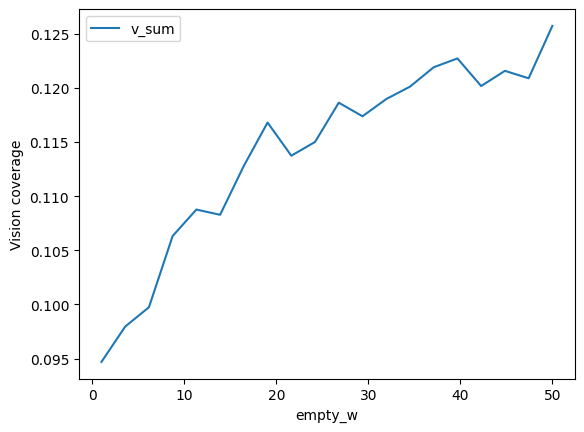

In [137]:
X = np.unique(empty_w)

iv = {"empty_w": [], "v_sum": []}
for x in X:
    mask = empty_w == x
    group_cubes = cubes[mask, :, :, :]
    #group_cubes_mean_experiments = np.mean(group_cubes, axis=0)
    iv["empty_w"].append(x)
    iv["v_sum"].append(np.mean(group_cubes))


iv = pd.DataFrame(iv)
ax = iv.sort_values("empty_w").plot.line("empty_w", "v_sum")
ax.set_ylabel("Vision coverage")

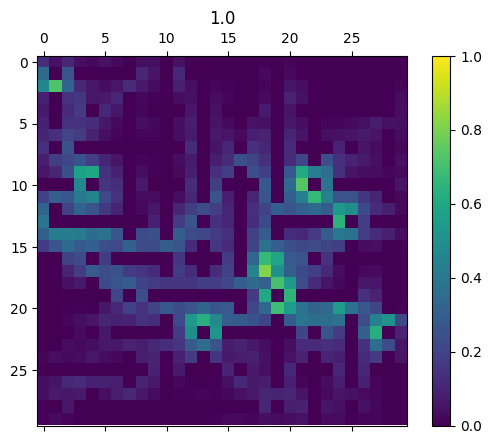

In [127]:
X = np.unique(empty_w)

for x in X:
    mask = empty_w == x
    cube = cubes[mask, :, :, :][0, :, :, :]

    fig, ax = plt.subplots()
    ax.set_title(x)
    mappable = ax.matshow(np.mean(cube, axis=0), vmin=0, vmax=1)
    fig.colorbar(mappable)
    plt.show()
    break

Text(0, 0.5, 'N of thefts')

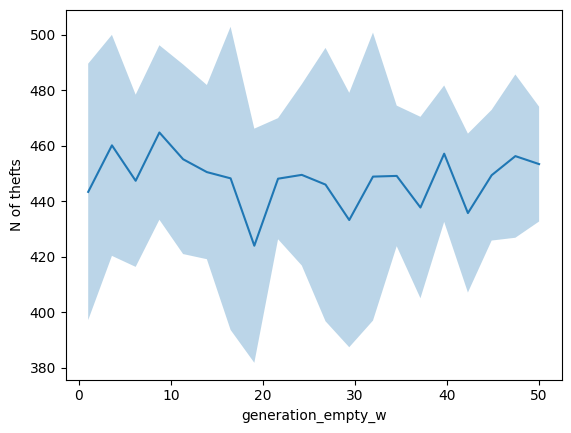

In [138]:
g = df.groupby(["rand", "generation_empty_w"])["caught"].value_counts()
g = g.reset_index()
g = g[~g["caught"]]

interest = "generation_empty_w"
def process(df: pd.DataFrame):
    return pd.DataFrame({"stole_mean": [df["count"].mean()], "stole_std": [df["count"].std()]})

g = g.groupby("generation_empty_w").apply(process)
g = g.reset_index().drop(columns="level_1")


fig, ax = plt.subplots()
ax.plot(g[interest], g["stole_mean"])
upper = g["stole_mean"] + g["stole_std"]
lower = g["stole_mean"] - g["stole_std"]

ax.fill_between(g[interest], upper, lower, alpha=0.3)
ax.set_xlabel(interest)
ax.set_ylabel("N of thefts")

<Axes: xlabel='generation_empty_w'>

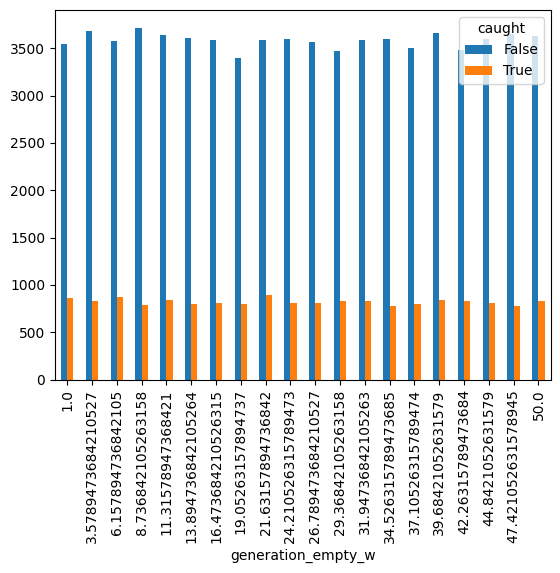

In [139]:
caught = df[df["caught"]]

df.groupby(interest)["caught"].value_counts().unstack().plot.bar()

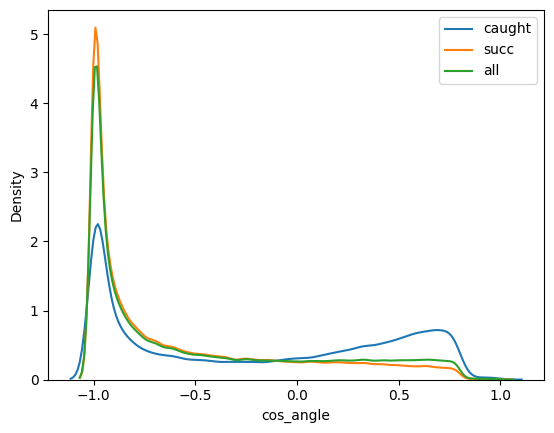

In [140]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

sns.kdeplot(df.loc[df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="caught")
sns.kdeplot(df.loc[~df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="succ")
sns.kdeplot(df.loc[:, "cos_angle"], bw_adjust=0.4, ax=ax, label="all")

ax.legend()
plt.show()

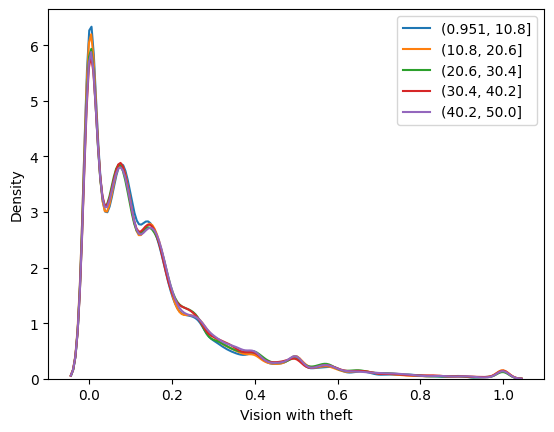

In [143]:
fig, ax = plt.subplots()


df["w_empty_bin"] = pd.cut(df[interest], bins=5)

for interval in df["w_empty_bin"].unique():
    empty_bin_df = df[df["w_empty_bin"] == interval]
    sns.kdeplot(empty_bin_df.loc[:, "vision"], bw_adjust=0.6, ax=ax, label=str(interval))

ax.set_xlabel("Vision with theft")
ax.legend()
plt.show()

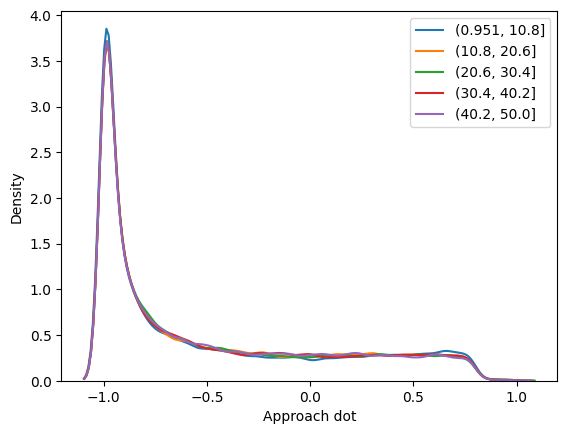

In [142]:
fig, ax = plt.subplots()


df["w_empty_bin"] = pd.cut(df[interest], bins=5)

for interval in df["w_empty_bin"].unique():
    empty_bin_df = df[df["w_empty_bin"] == interval]
    sns.kdeplot(empty_bin_df.loc[:, "cos_angle"], bw_adjust=0.4, ax=ax, label=str(interval))

ax.set_xlabel("Approach dot")
ax.legend()
plt.show()

<Axes: xlabel='others <-> target', ylabel='Density'>

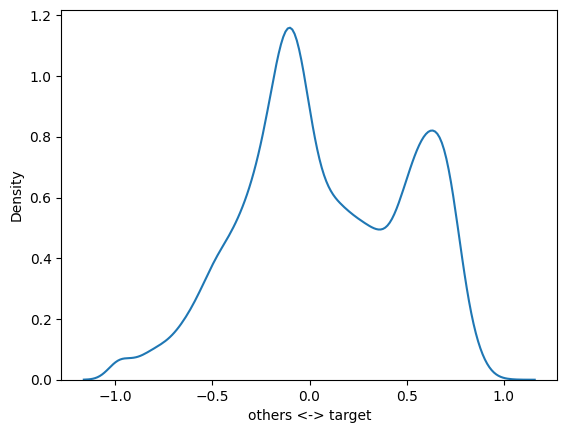

In [133]:


caught = df[df["caught"]].copy()
caught["p_target"] = caught["cos_angle"] / 2 + 0.5
caught["p_other"] = caught["vision"]

caught["others <-> target"] = caught["p_target"] - caught["p_other"]

sns.kdeplot(caught["others <-> target"])